In [1]:
import os
import re

import torch
import IPython
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from g2pk import G2p
from tqdm.notebook import tqdm

from models.transformer_tts import TransformerTTS
from models.pl_model import PLTransformerTTS
from tokenizer import Tokenizer
from datasets import get_datasets


# g2p = G2p()

In [2]:
tokenizer = Tokenizer('./tokenizer/rulebook.txt')

In [3]:
train_dataset, eval_dataset = get_datasets(
    [
        "/home/nsw0311/nas_storage/datasets/tts/processed_data_24000/ine/"
    ],
    tokenizer,
    max_ids_length=128,
    max_spectrogram_length=512,
    train_ratio=0.9,
    seed=42,
)

In [4]:
from torch.utils.data import DataLoader, Dataset


dataloader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 1,
    prefetch_factor = 16,
    pin_memory = True,
)

# phoneme dict

In [ ]:
import glob


dirs = [
    "/home/nsw0311/nas_storage/datasets/tts/processed_data_24000/ine/",
    "/home/nsw0311/nas_storage/datasets/tts/processed_data_24000/kaist_female/",
    "/home/nsw0311/nas_storage/datasets/tts/processed_data_24000/kaist_male/"
]


file_list = []

for path in dirs:
    file_list += glob.glob(os.path.join(path, "*.pt"))

In [ ]:
p = re.compile(r"[^ ㄱ-ㅎㅏ-ㅣ가-힣a-z0-9…~!?,.]")
tokens = set()


for path in tqdm(file_list):
    file = torch.load(path)
    
    text = file['text'].replace("...", "…")
    text = p.sub("", text).strip()

    text = g2p(text, descriptive=True)
    tokens.update(set(text))

In [ ]:
tokens = sorted(tokens)
tokens

In [ ]:
# tokens = ["[PAD]", "[UNK]"] + tokens
token_dict = {t: i for i, t in enumerate(tokens)}

In [ ]:
import json


with open("/home/nsw0311/nas_storage/etc/transformer_tts_tokenizer.json", "w", encoding="utf-8") as f:
    json.dump(token_dict, f)
token_dict

In [ ]:
os.chdir("/home/nsw0311/nas_storage/datasets/tts/processed_data/ine/")
file_list = sorted(os.listdir())
file_size = [os.path.getsize(f) for f in file_list]
longest_file = file_list[np.argmax(file_size)]

In [ ]:
path = longest_file
sample = torch.load(path)

wave = sample["waveform"]
spectrogram = sample["mel_spectrogram"]
text = sample['text']

In [ ]:
text

In [ ]:
spectrogram.shape

In [ ]:
IPython.display.Audio(wave, rate=16000)

# model test

In [13]:
isunk = 0
for x, y in tqdm(dataloader):
    isunk += x['input_ids'].eq(1).sum()
    
isunk

  0%|          | 0/60 [00:00<?, ?it/s]

tensor(2)

tensor(0)

In [6]:
plmodel = PLTransformerTTS.load_from_checkpoint("/home/nsw0311/nas_storage/ckpt/transformer_tts/epoch=5999.ckpt")
model = plmodel.model

In [5]:
model = TransformerTTS(5120)

In [6]:
model.eval()

with torch.no_grad():
    for x, y in dataloader:
        mel_output, mel_post_output, stop_output, e_score, d_score, de_score = model(**x)
        break

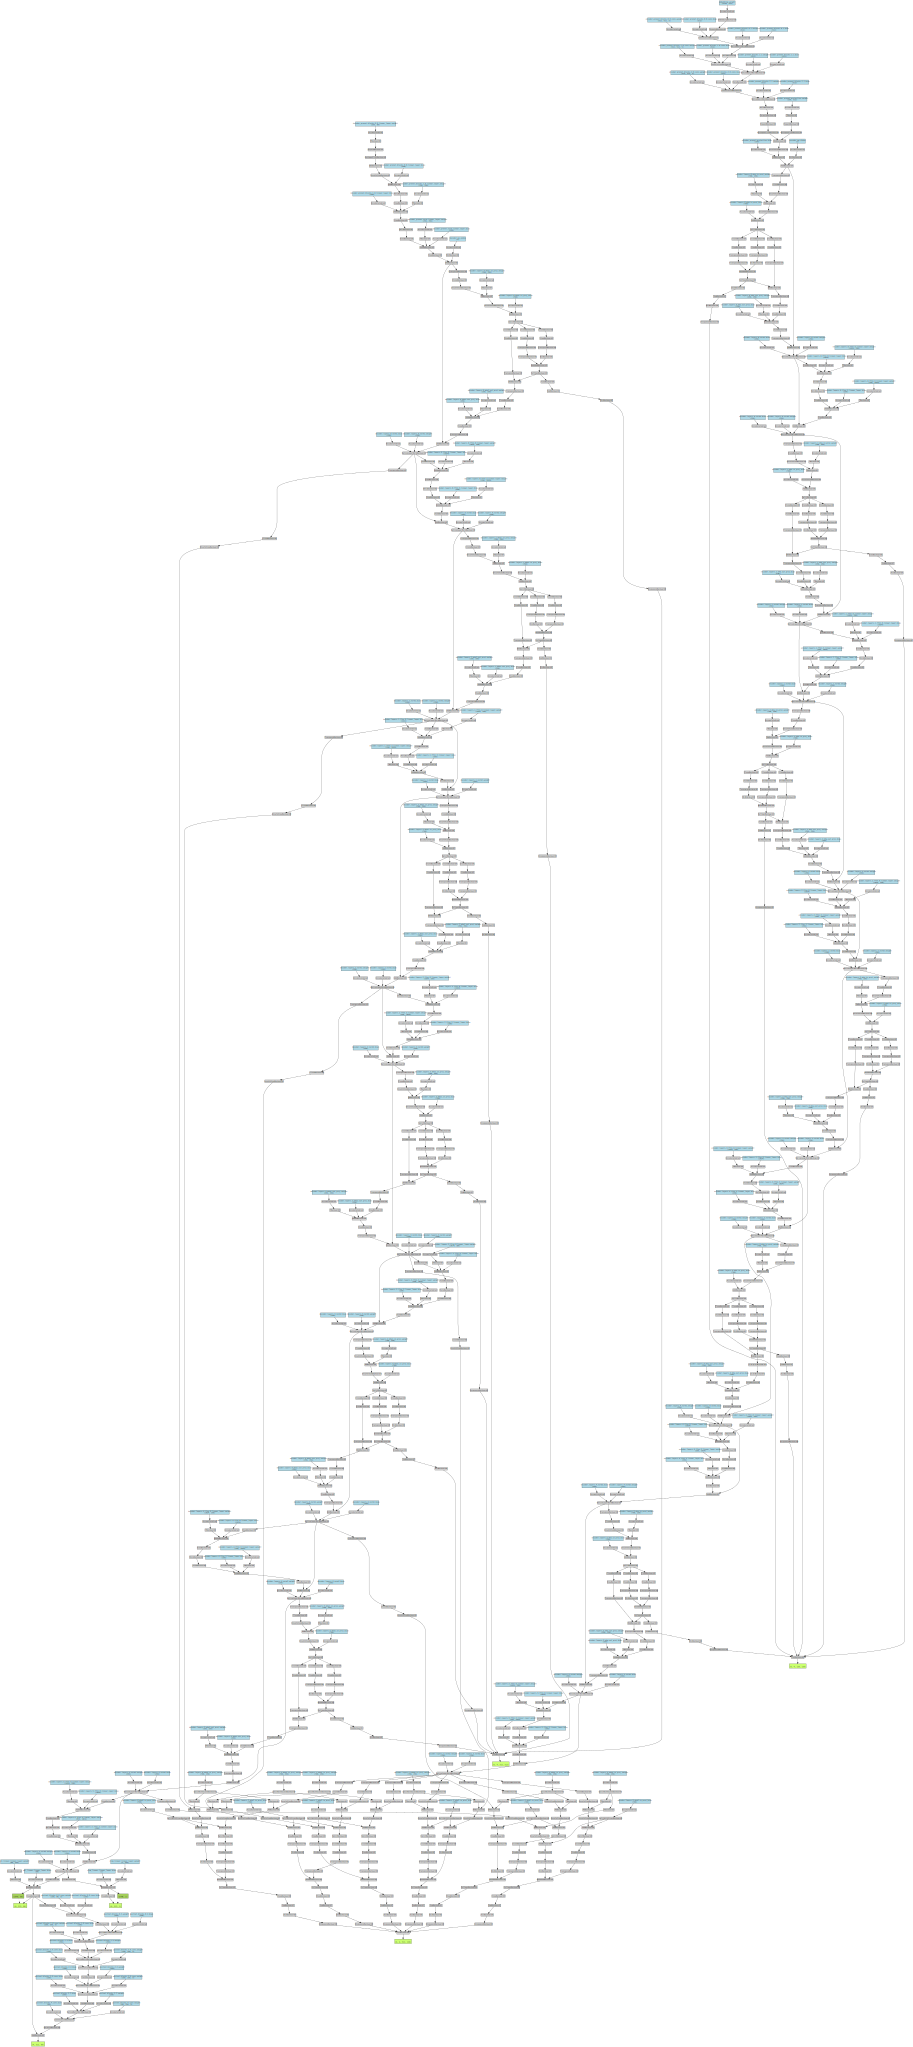

In [7]:
from torchviz import make_dot

make_dot(model(**x), params=dict(model.named_parameters()))

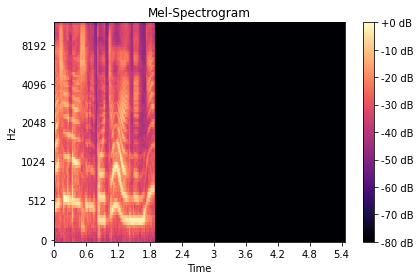

In [14]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


librosa.display.specshow(
    librosa.power_to_db(y['mel_label'][0], ref=np.max), 
    y_axis='mel', 
    sr=24000, 
    hop_length=256, 
    x_axis='time'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

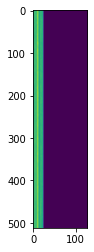

In [40]:
plt.imshow(de_score[0][0])
plt.show()

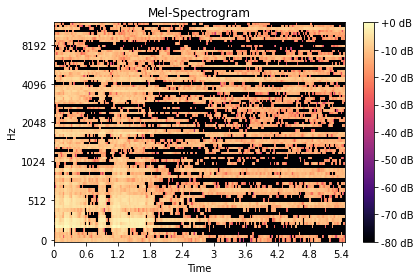

In [16]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


librosa.display.specshow(
    librosa.power_to_db(mel_output[0].permute(1, 0), ref=np.max), 
    y_axis='mel', 
    sr=24000, 
    hop_length=256, 
    x_axis='time'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

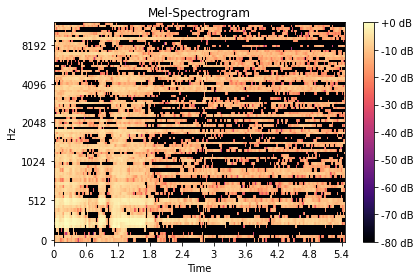

In [17]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


librosa.display.specshow(
    librosa.power_to_db(mel_post_output[0].permute(1, 0), ref=np.max), 
    y_axis='mel', 
    sr=24000, 
    hop_length=256, 
    x_axis='time'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

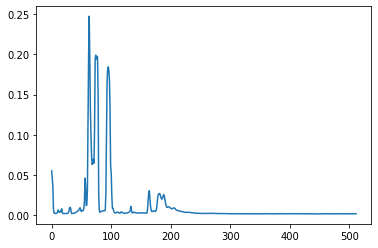

In [18]:
plt.plot(torch.sigmoid(stop_output[0, :, 0]))
plt.show()

In [27]:
import torch.nn as nn

transformer_model = nn.Transformer(
    d_model=256,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024,
    dropout=0.1,
    batch_first=True,
)
src = torch.rand((4, 32, 256))
tgt = torch.rand((4, 64, 256))
out = transformer_model(src, tgt)

In [29]:
transformer_model.encoder.layers[0].self_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
)

In [ ]:
from torchviz import make_dot
from torch.autograd import Variable

model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())

# Variable을 통하여 Input 생성
x = Variable(torch.randn(1, 8)) 

# 앞에서 생성한 model에 Input을 x로 입력한 뒤 (model(x))  graph.png 로 이미지를 출력합니다.
make_dot(model(x), params=dict(model.named_parameters())).render("graph", format="png")